In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import warnings
from matplotlib.pyplot import figure
import seaborn as sns
from pmdarima import auto_arima
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Erathna_multivariate.csv',parse_dates=['Time'], index_col='Time')
df.head()

,Power,Temp_min,Temp_max,Hum_min,Hum_max,Rainfall
Time,,,,,,
2013-01-01,1337701,22.0,31.9,75.3,94.3,71.400000
2013-02-01,1170096,22.5,33.5,72.3,94.3,217.899999
2013-03-01,1604287,23.1,34.0,77.4,97.4,312.399998
2013-04-01,2060601,24.1,34.3,76.1,97.2,202.599999
2013-05-01,6133238,24.5,31.5,82.9,95.2,569.399997


In [3]:
#Checking for missing values
df.isna().sum()

Power        0
Temp_min     1
Temp_max     1
Hum_min      1
Hum_max     10
Rainfall     5
dtype: int64

In [4]:
df=df.resample('MS').first()

In [5]:
#removing missing values
df=df.fillna(method='bfill')
df.head()

,Power,Temp_min,Temp_max,Hum_min,Hum_max,Rainfall
Time,,,,,,
2013-01-01,1337701,22.0,31.9,75.3,94.3,71.400000
2013-02-01,1170096,22.5,33.5,72.3,94.3,217.899999
2013-03-01,1604287,23.1,34.0,77.4,97.4,312.399998
2013-04-01,2060601,24.1,34.3,76.1,97.2,202.599999
2013-05-01,6133238,24.5,31.5,82.9,95.2,569.399997


In [6]:
df=df[['Temp_min','Temp_max','Hum_min','Hum_max','Rainfall']]

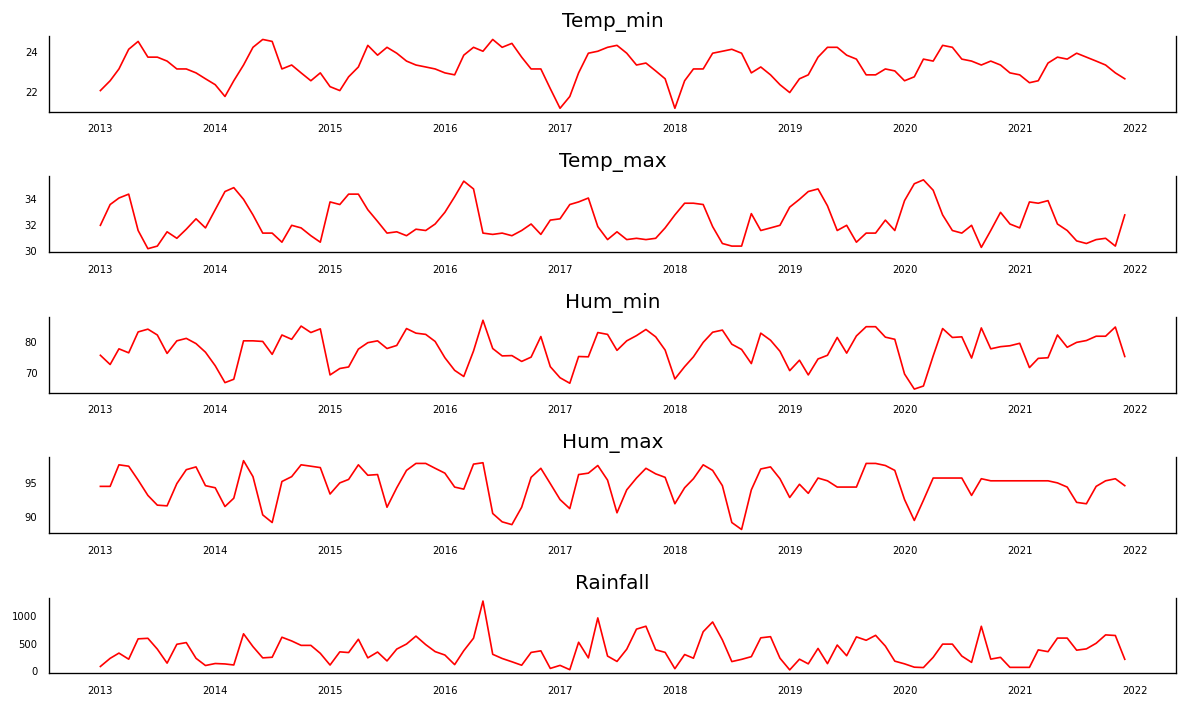

In [7]:
fig, axes = plt.subplots(nrows=5, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

    H0: Series is not stationary
    H1: Series is Stationary

In [8]:
### ADF Test
col=df.columns
for i in range(len(col)):
    test_result=adfuller(df[col[i]])
    def adfuller_test(x):
        result=adfuller(x)
        labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
        for value,label in zip(result,labels):
            print(label+' : '+str(value) )
        if result[1] <= 0.05:
            print("strong evidence against the null hypothesis(Ho), reject the null hypothesis.Therefore, "+col[i]+" series is stationary")
        else:
            print("weak evidence against null hypothesis, time series has a unit root, indicating " + col[i] + " series is non-stationary ")

    adfuller_test(df[col[i]])

ADF Test Statistic : -2.1280093887612805
p-value : 0.23340203111752356
#Lags Used : 12
Number of Observations Used : 95
weak evidence against null hypothesis, time series has a unit root, indicating Temp_min series is non-stationary 
ADF Test Statistic : -1.71084269823937
p-value : 0.42553482915755203
#Lags Used : 11
Number of Observations Used : 96
weak evidence against null hypothesis, time series has a unit root, indicating Temp_max series is non-stationary 
ADF Test Statistic : -3.275694914074333
p-value : 0.016000490779204558
#Lags Used : 10
Number of Observations Used : 97
strong evidence against the null hypothesis(Ho), reject the null hypothesis.Therefore, Hum_min series is stationary
ADF Test Statistic : -3.606960339329288
p-value : 0.0056293467706235705
#Lags Used : 13
Number of Observations Used : 94
strong evidence against the null hypothesis(Ho), reject the null hypothesis.Therefore, Hum_max series is stationary
ADF Test Statistic : -5.330290938348099
p-value : 4.737581600

#### According to the ADF test, only the Temp_min and Temp_max series are non-stationary. Therefore it needs to difference the series.

In [9]:
ad_fuller_result_1 = adfuller(df['Temp_min'].diff()[1:])

print('Temp_min')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

Temp_min
ADF Statistic: -5.4362520869722335
p-value: 2.841277057912391e-06


In [10]:
ad_fuller_result_2 = adfuller(df['Temp_max'].diff()[1:])

print('Temp_max')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

Temp_max
ADF Statistic: -9.687516655860511
p-value: 1.1598777095571225e-16


In [11]:
#Combine first differenced Temp_min with rest.
df['Temp_min']=df['Temp_min'].diff()[1:]
df['Temp_max']=df['Temp_max'].diff()[1:]
#df= df.iloc[1: , :] #Remioving the first column
#Checking for missing values
df.isna().sum()

Temp_min    1
Temp_max    1
Hum_min     0
Hum_max     0
Rainfall    0
dtype: int64

In [12]:
#removing missing values
df=df.dropna(how="any")
df.head()

,Temp_min,Temp_max,Hum_min,Hum_max,Rainfall
Time,,,,,
2013-02-01,0.5,1.6,72.3,94.3,217.899999
2013-03-01,0.6,0.5,77.4,97.4,312.399998
2013-04-01,1.0,0.3,76.1,97.2,202.599999
2013-05-01,0.4,-2.8,82.9,95.2,569.399997
2013-06-01,-0.8,-1.4,83.8,93.0,578.999999


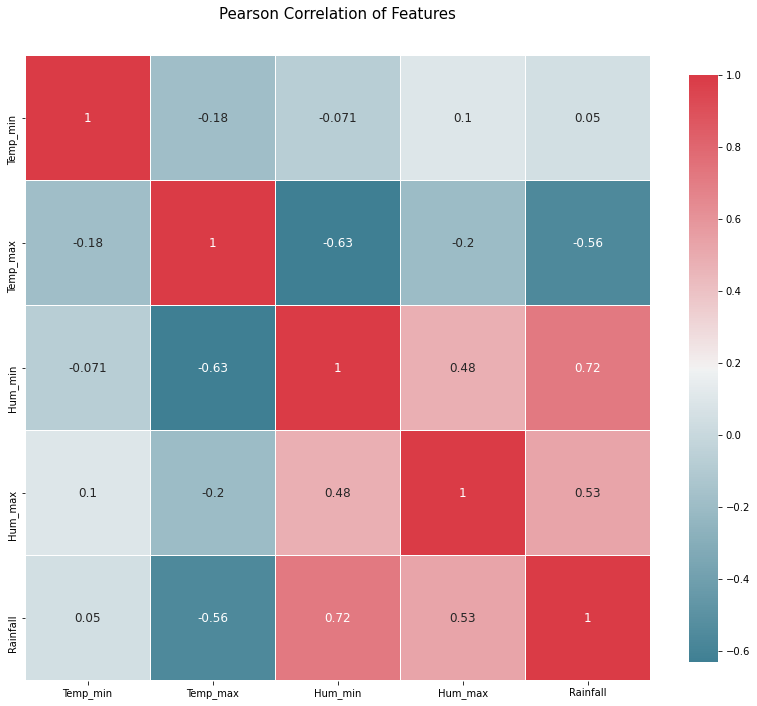

In [13]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(df)

# Fitting ARIMAX model

In [53]:
#Re-importing dataset without setting the index on time axis.
df_1 = pd.read_csv('Erathna_multivariate.csv')
#Removing first row
df_2= df_1.iloc[1: , :]
#Remove Temp_min and Temp_max columns
df_2=df_2.drop(columns=['Temp_min','Temp_max'])

#Concat the dataframe with first differenced Temp_min with first row removed dataframe
df=pd.concat([df_2,df_1['Temp_min'].diff()[1:],df_1['Temp_max'].diff()[1:]],axis=1)
#removing missing values
df=df.dropna(how="any")
df.head()

,Power,Time,Hum_min,Hum_max,Rainfall,Temp_min,Temp_max
1,1170096,2013-February,72.3,94.3,217.899999,0.5,1.6
2,1604287,2013-March,77.4,97.4,312.399998,0.6,0.5
3,2060601,2013-April,76.1,97.2,202.599999,1.0,0.3
4,6133238,2013-May,82.9,95.2,569.399997,0.4,-2.8
5,6996320,2013-June,83.8,93.0,578.999999,-0.8,-1.4


### Feature Engineering

In [54]:
def feature_engineering(data):
    data['Time'] = pd.to_datetime(data['Time'])
    data["Time"] = pd.to_datetime(data["Time"], format="%Y-%m-%d")
    data["year"] = data["Time"].dt.year
    data["month"] = data["Time"].dt.month
    
    lag_features = ["Rainfall","Temp_min","Temp_max","Hum_min","Hum_max"]
    window1 = 2
    window2 = 3
    window3 = 7

    data_rolled_2d = data[lag_features].rolling(window=window1, min_periods=0)
    data_rolled_3d = data[lag_features].rolling(window=window2, min_periods=0)
    data_rolled_7d = data[lag_features].rolling(window=window3, min_periods=0)

    data_mean_2d = data_rolled_2d.mean().shift(1)
    data_mean_3d = data_rolled_3d.mean().shift(1)
    data_mean_7d = data_rolled_7d.mean().shift(1)
    
    data_std_2d = data_rolled_2d.std().shift(1)
    data_std_3d = data_rolled_3d.std().shift(1)
    data_std_7d = data_rolled_7d.std().shift(1)

    for feature in lag_features:
        data[f"{feature}_mean_lag{window1}"] = data_mean_2d[feature]
        data[f"{feature}_mean_lag{window2}"] = data_mean_3d[feature]
        data[f"{feature}_mean_lag{window3}"] = data_mean_7d[feature]

        data[f"{feature}_std_lag{window1}"] = data_std_2d[feature]
        data[f"{feature}_std_lag{window2}"] = data_std_3d[feature]
        data[f"{feature}_std_lag{window3}"] = data_std_7d[feature]

    data.fillna(data.mean(), inplace=True)
    
feature_engineering(df)

In [55]:
df.head()

,Power,Time,Hum_min,Hum_max,Rainfall,Temp_min,Temp_max,year,month,Rainfall_mean_lag2,...,Hum_min_mean_lag7,Hum_min_std_lag2,Hum_min_std_lag3,Hum_min_std_lag7,Hum_max_mean_lag2,Hum_max_mean_lag3,Hum_max_mean_lag7,Hum_max_std_lag2,Hum_max_std_lag3,Hum_max_std_lag7
1,1170096,2013-02-01,72.3,94.3,217.899999,0.5,1.6,2013,2,352.466666,...,76.909229,2.862245,3.622290,4.812557,94.428495,94.429211,94.473193,1.411908,1.887084,2.332263
2,1604287,2013-03-01,77.4,97.4,312.399998,0.6,0.5,2013,3,217.899999,...,72.300000,2.862245,3.622290,4.812557,94.300000,94.300000,94.300000,1.411908,1.887084,2.332263
3,2060601,2013-04-01,76.1,97.2,202.599999,1.0,0.3,2013,4,265.149999,...,74.850000,3.606245,3.606245,3.606245,95.850000,95.850000,95.850000,2.192031,2.192031,2.192031
4,6133238,2013-05-01,82.9,95.2,569.399997,0.4,-2.8,2013,5,257.499999,...,75.266667,0.919239,2.650157,2.650157,97.300000,96.300000,96.300000,0.141421,1.734935,1.734935
5,6996320,2013-06-01,83.8,93.0,578.999999,-0.8,-1.4,2013,6,385.999998,...,77.175000,4.808326,3.609709,4.387387,96.200000,96.600000,96.025000,1.414214,1.216553,1.519594


In [56]:
#Checking for missing values
df.isnull().sum()

Power                 0
Time                  0
Hum_min               0
Hum_max               0
Rainfall              0
Temp_min              0
Temp_max              0
year                  0
month                 0
Rainfall_mean_lag2    0
Rainfall_mean_lag3    0
Rainfall_mean_lag7    0
Rainfall_std_lag2     0
Rainfall_std_lag3     0
Rainfall_std_lag7     0
Temp_min_mean_lag2    0
Temp_min_mean_lag3    0
Temp_min_mean_lag7    0
Temp_min_std_lag2     0
Temp_min_std_lag3     0
Temp_min_std_lag7     0
Temp_max_mean_lag2    0
Temp_max_mean_lag3    0
Temp_max_mean_lag7    0
Temp_max_std_lag2     0
Temp_max_std_lag3     0
Temp_max_std_lag7     0
Hum_min_mean_lag2     0
Hum_min_mean_lag3     0
Hum_min_mean_lag7     0
Hum_min_std_lag2      0
Hum_min_std_lag3      0
Hum_min_std_lag7      0
Hum_max_mean_lag2     0
Hum_max_mean_lag3     0
Hum_max_mean_lag7     0
Hum_max_std_lag2      0
Hum_max_std_lag3      0
Hum_max_std_lag7      0
dtype: int64

In [57]:
#Splitting the data set to train and test
train=df[:int(0.67*(len(df)))]
valid=df[int(0.67*(len(df))):]

In [58]:
features=df.columns
print(features)

Index(['Power', 'Time', 'Hum_min', 'Hum_max', 'Rainfall', 'Temp_min',
       'Temp_max', 'year', 'month', 'Rainfall_mean_lag2', 'Rainfall_mean_lag3',
       'Rainfall_mean_lag7', 'Rainfall_std_lag2', 'Rainfall_std_lag3',
       'Rainfall_std_lag7', 'Temp_min_mean_lag2', 'Temp_min_mean_lag3',
       'Temp_min_mean_lag7', 'Temp_min_std_lag2', 'Temp_min_std_lag3',
       'Temp_min_std_lag7', 'Temp_max_mean_lag2', 'Temp_max_mean_lag3',
       'Temp_max_mean_lag7', 'Temp_max_std_lag2', 'Temp_max_std_lag3',
       'Temp_max_std_lag7', 'Hum_min_mean_lag2', 'Hum_min_mean_lag3',
       'Hum_min_mean_lag7', 'Hum_min_std_lag2', 'Hum_min_std_lag3',
       'Hum_min_std_lag7', 'Hum_max_mean_lag2', 'Hum_max_mean_lag3',
       'Hum_max_mean_lag7', 'Hum_max_std_lag2', 'Hum_max_std_lag3',
       'Hum_max_std_lag7'],
      dtype='object')


In [68]:
#Removing predictor variablel,power and time column
features=['Hum_min', 'Hum_max','Temp_min',
       'Temp_max','Rainfall_mean_lag2', 'Rainfall_mean_lag3',
       'Rainfall_mean_lag7', 'Rainfall_std_lag2', 'Rainfall_std_lag3',
       'Rainfall_std_lag7', 'Temp_min_mean_lag2', 'Temp_min_mean_lag3',
       'Temp_min_mean_lag7', 'Temp_min_std_lag2', 'Temp_min_std_lag3',
       'Temp_min_std_lag7', 'Temp_max_mean_lag2', 'Temp_max_mean_lag3',
       'Temp_max_mean_lag7', 'Temp_max_std_lag2', 'Temp_max_std_lag3',
       'Temp_max_std_lag7', 'Hum_min_mean_lag2', 'Hum_min_mean_lag3',
       'Hum_min_mean_lag7', 'Hum_min_std_lag2', 'Hum_min_std_lag3',
       'Hum_min_std_lag7', 'Hum_max_mean_lag2', 'Hum_max_mean_lag3',
       'Hum_max_mean_lag7', 'Hum_max_std_lag2', 'Hum_max_std_lag3',
       'Hum_max_std_lag7']

In [80]:
arimaxmodel = auto_arima(train['Rainfall'],
                   exogenous = train[features], trace=True, 
                   error_action="ignore", suppress_warnings=True,stepwise=False,start_P=1,start_Q=1,max_d=2,max_D=2,m=12,max_p=6,max_q=6,maxiter=20,alpha=0.05,trend='ct',information_criterion='aic',out_of_sample_size=int(len(train)*0.2))
arimaxmodel.fit(train['Rainfall'], exogenous = train[features])
# model = arima()
arimaxforecast = arimaxmodel.predict(n_periods=len(valid), exogenous = valid[features])
valid["Forecast_ARIMAX"] = arimaxforecast

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=980.772, Time=1.46 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=983.090, Time=2.15 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=972.637, Time=5.60 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=985.516, Time=1.98 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=2.66 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=991.112, Time=6.25 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=987.001, Time=5.11 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=989.819, Time=5.37 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=989.856, Time=6.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=992.156, Time=1.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=982.892, Time=2.17 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=978.708, Time=6.31 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=983.291, Time=2.07 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=2.48 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=973.862, Time=6.03 sec
 ARIMA(0,0,1)(2,0,

In [81]:
arimaxmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:                             y   No. Observations:                   62
Model:             SARIMAX(0, 0, [1, 2], 12)   Log Likelihood                -447.319
Date:                       Sun, 24 Apr 2022   AIC                            972.637
Time:                               11:35:30   BIC                           1055.595
Sample:                                    0   HQIC                          1005.209
                                        - 62                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -6.7918   5791.764     -0.001      0.999   -1.14e+04    1.13e+04
drift          0.2033      1.743      0.117      0.907      -3.213       3.620
x1            10.0699     18.082      0.557      0.578     -25.370      45.510
x2            27.9498     28.533      0.980      0.327     -27.974      83.874
x3            35.5284     54.307      0.654      0.513     -70.912     141.968
x4          -103.6390     47.522     -2.181      0.029    -196.780     -10.498
x5             1.4805      0.543      2.725      0.006       0.416       2.545
x6            -1.5832      0.770     -2.057      0.040      -3.092      -0.075
x7             0.1775      0.634      0.280      0.780      -1.065       1.420
x8            -0.4473      0.158     -2.826      0.005      -0.758      -0.137
x9             0.3709      0.397      0.934      0.351      -0.408       1.150
x10            0.1228      0.517      0.237      0.812      -0.891       1.136
x11         -110.0558    116.033     -0.948      0.343    -337.477     117.365
x12          278.4167    127.550      2.183      0.029      28.423     528.411
x13           89.1820    192.167      0.464      0.643    -287.459     465.823
x14          159.7902     85.382      1.871      0.061      -7.555     327.135
x15         -284.9100     91.993     -3.097      0.002    -465.212    -104.608
x16          465.6638    202.725      2.297      0.022      68.329     862.998
x17         -267.9221     97.305     -2.753      0.006    -458.636     -77.208
x18          111.5537    126.541      0.882      0.378    -136.462     359.569
x19           92.2272    180.576      0.511      0.610    -261.694     446.149
x20          -25.9076     45.264     -0.572      0.567    -114.624      62.809
x21          107.5187     57.814      1.860      0.063      -5.795     220.832
x22         -326.8267     81.284     -4.021      0.000    -486.140    -167.513
x23         -127.7919     36.087     -3.541      0.000    -198.522     -57.062
x24          125.3197     48.071      2.607      0.009      31.103     219.536
x25           38.6567     39.374      0.982      0.326     -38.516     115.829
x26           41.6434     15.321      2.718      0.007      11.615      71.672
x27          -27.4681     18.725     -1.467      0.142     -64.168       9.232
x28           -5.3300     23.903     -0.223      0.824     -52.179      41.518
x29            8.6615     42.317      0.205      0.838     -74.279      91.602
x30          -44.4179     53.572     -0.829      0.407    -149.417      60.582
x31          -24.1881     77.463     -0.312      0.755    -176.012     127.636
x32          -17.0295     22.874     -0.745      0.457     -61.861      27.802
x33           -0.9283     24.045     -0.039      0.969     -48.056      46.199
x34          -49.9829     49.562     -1.008      0.313    -147.123      47.157
ma.S.L12       0.0336      0.347      0.097      0.923      -0.647       0.714
ma.S.L24      -0.4

(Text(0.5, 1.0, 'Rainfall Forecasting'), 'Forecast_ARIMAX')

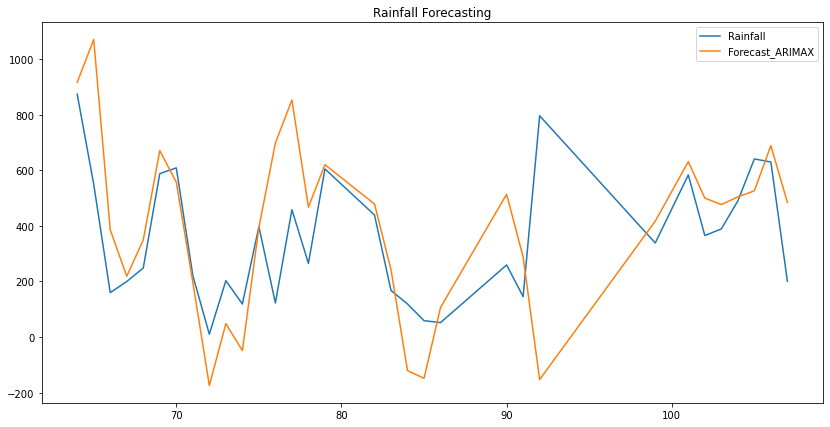

In [82]:
#Forecast using built model
valid[["Rainfall","Forecast_ARIMAX"]].plot(figsize=(14, 7))
plt.title('Rainfall Forecasting'), "Forecast_ARIMAX"